### STREAM mapping approach:
Using a set of cells as reference, construct a pseudotime trajectory. Map other cells of interest into this same space.

For this analysis, NSCLC used as reference and glioma and melanoma mapped onto it.

Here, process NSCLC to reference STREAM object

In [2]:
## Import modules
import stream as st
import scanpy
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import os
from pandas.plotting import table 
st.__version__

/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


'1.1'

### Settings for STREAM, saving output

In [3]:
## Set analysis name- for reading/writing data
analysis_name="cd8_nsclc"

## Number of variable genes
n_genes=500

## dimensionality reduction settings
method='mlle'
n_components=4
n_neighbors=50

## STREAM settings
n_clusters=10
epg_alpha=0.02
epg_mu=0.05
epg_lambda=0.05
epg_shift_radius=0.1
epg_shift_max=3
epg_ext_par=0.8

### Load in hfad object (from seurat)

In [4]:
filename="analysis/STREAM/" + analysis_name + ".h5ad"
adata = scanpy.read_h5ad(filename)
st.set_workdir(adata,'./stream_result')

Saving results in: ./stream_result


### Preprocess count matrix

In [5]:
## Make variable names unique
adata.var_names_make_unique()

## Convert to array
adata.X=adata.X.toarray()

## Calculate QC metrics
st.cal_qc(adata,assay='rna')

###Remove mitochondrial genes 
st.remove_mt_genes(adata)

### Dimensionality reduction

/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:228: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)


500 variable genes are selected
feature var_genes is being used ...
4 cpus are being used ...


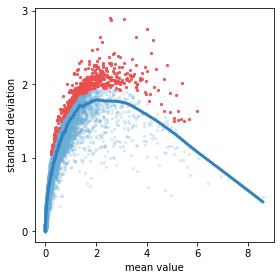

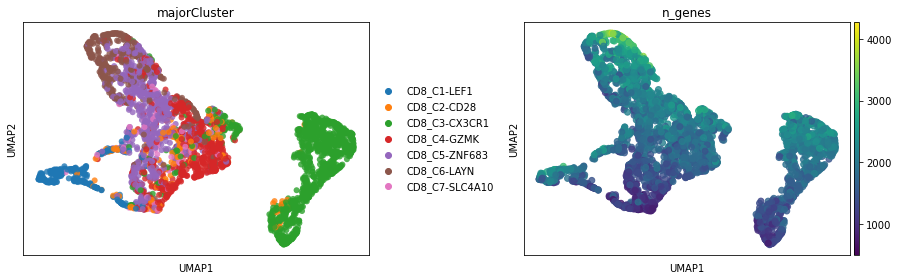

In [6]:
## select Variable genes
st.select_variable_genes(adata,loess_frac=0.01, n_genes=n_genes)

## dimension reduction
st.dimension_reduction(adata,method=method,feature='var_genes',n_components=n_components,n_neighbors=n_neighbors,n_jobs=4)

st.plot_visualization_2D(adata,n_neighbors=50,method='umap',color=['majorCluster','n_genes'],use_precomputed=False)

### Run STREAM trajectory

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 5
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 3805 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

3||50
	
1.641
	
50
	
49
	
42
	
3
	
0
	
0
	
0.7848
	
0.7655
	
0.9719
	
0.9726
	
0.8232
	
0.03313
	
1.656
	
82.82
	
0


14.013 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 7
Shifting branching point to denser area ...
[1]
 "Moving the branching point at node 6"


[1]
 "Moving the branching point 

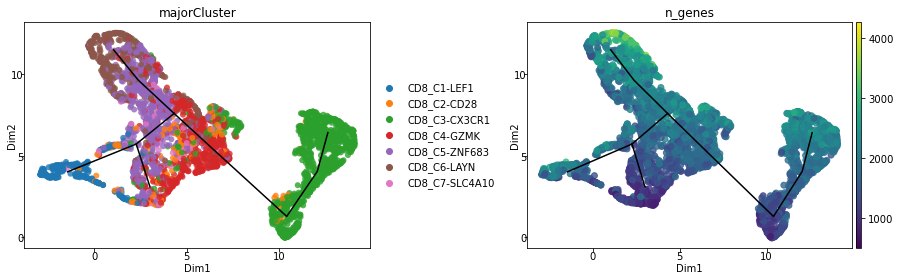

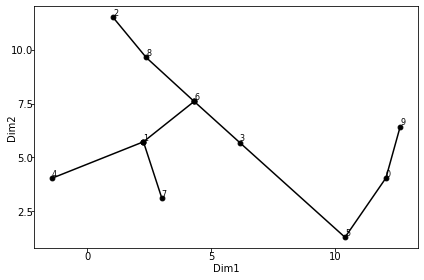

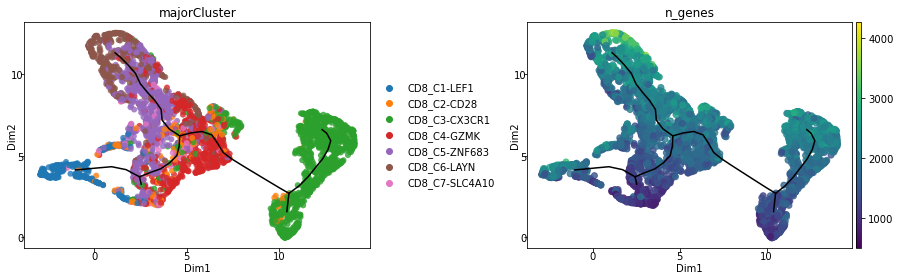

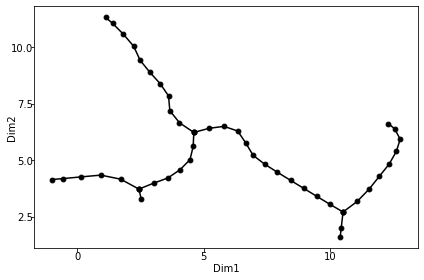

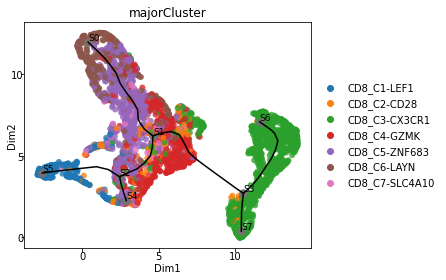

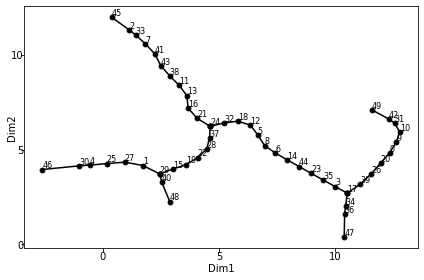

In [7]:
## Run trajectory
st.seed_elastic_principal_graph(adata,n_clusters=n_clusters,use_vis=True)
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)
st.elastic_principal_graph(adata,epg_alpha=epg_alpha,epg_mu=epg_mu,epg_lambda=epg_lambda)

## Edit branches
st.shift_branching(adata,epg_shift_mode='NodeDensity',epg_shift_radius=epg_shift_radius,epg_shift_max=epg_shift_max)
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
                                         
## Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=epg_ext_par)
st.plot_dimension_reduction(adata,color=['majorCluster'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

### Plot trajectory (reference only)

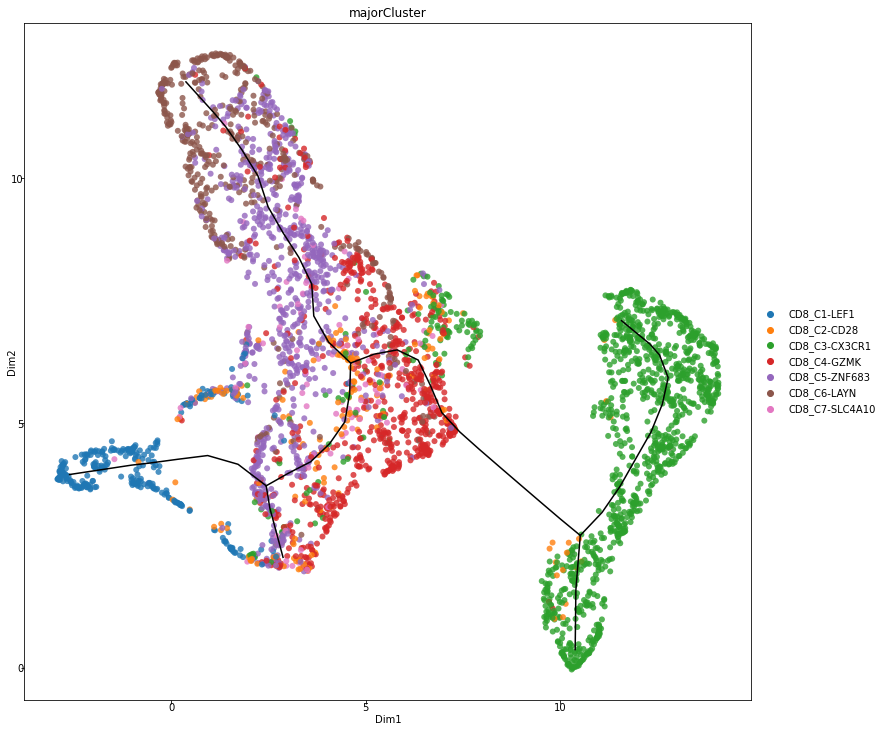

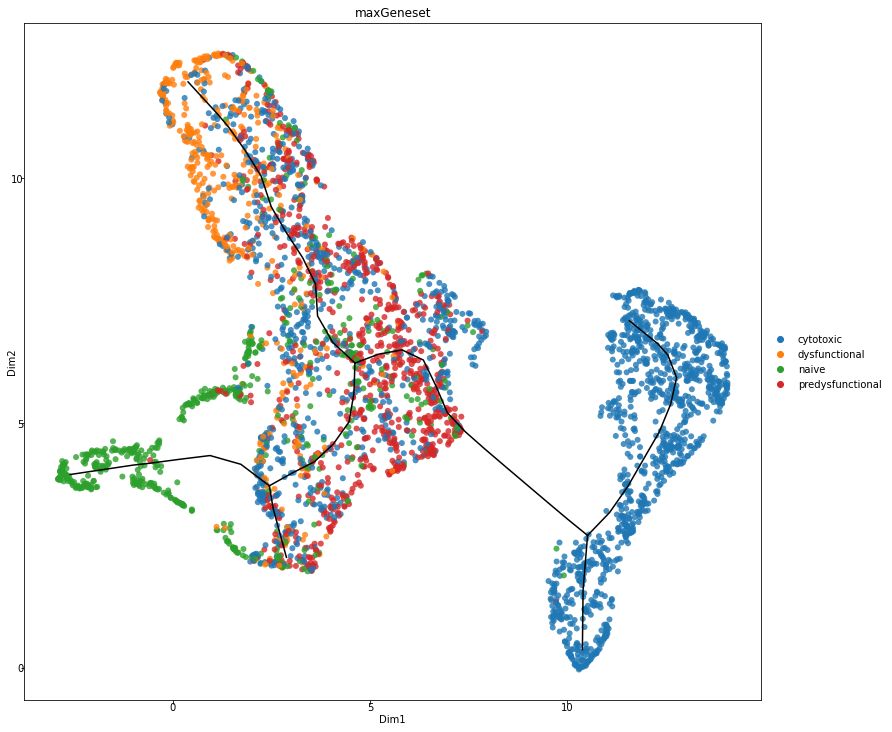

In [9]:
## by annotations from published dataset
st.plot_dimension_reduction(adata,color=["majorCluster"],show_graph=True,show_text=False)
figure = plt.gcf()

figure.set_size_inches(16, 12)
#plt.savefig(figure_dir + "/nsclc_trajectory_flat.pdf", dpi=600)

## By my annotations
st.plot_dimension_reduction(adata,color=["maxGeneset"],show_graph=True,show_text=False)
figure = plt.gcf()

figure.set_size_inches(16, 12)
#plt.savefig(figure_dir + "/nsclc_trajectory_flat_byMyCelltype.pdf", dpi=600)

### Save output

In [ ]:
filename='stream_result_' + analysis_name + '.pkl'
st.write(adata,file_name=filename)